In [ ]:
import re
import astropy.units as u

def _clean(quantity):
    txt = quantity.to_string(format='latex')
    if '$$' not in txt:
        return txt
    txt = re.sub(r'\$\$\s*\\mathrm', r'\\,\\mathrm', txt)
    txt = re.sub(r'\\mathrm\{\s*\\left\(', r'\\left(',  txt)
    txt = re.sub(r'\\right\)\s*\}',        r'\\right)', txt)

    return txt

u.quantity.Quantity._repr_latex_ = _clean

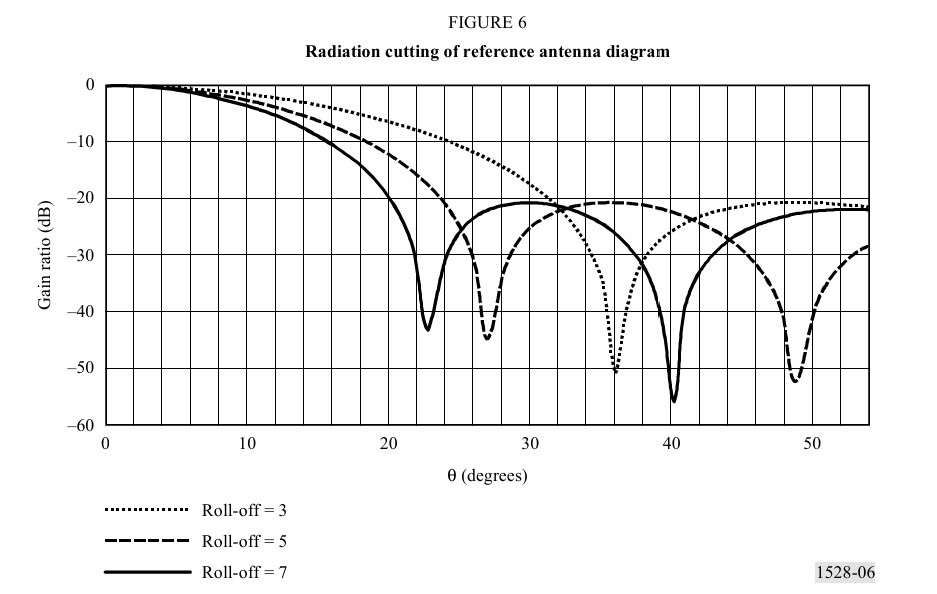

<Figure size 900x600 with 0 Axes>

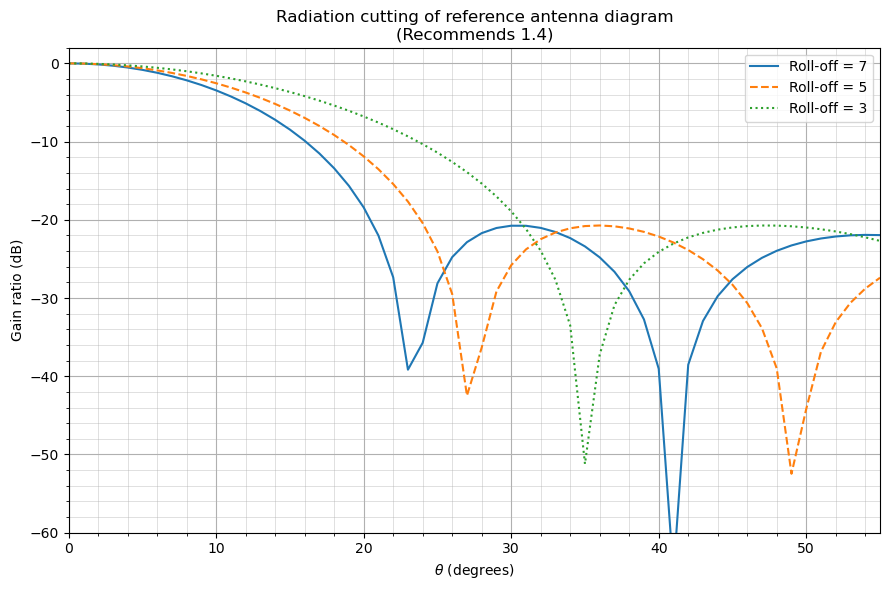

In [ ]:
import numpy as np
from scipy import special as sp
try:
    from numba import njit            # optional – keeps import very cheap if absent
    _have_numba = True
except ImportError:                   # pragma: no cover
    _have_numba = False

import astropy.units as u
from pycraf import conversions as cnv
from pycraf.utils import ranged_quantity_input

# optional fast product evaluator
if _have_numba:
    @njit(cache=True, fastmath=True, nogil=True)
    def _prod_numba(u_flat, pi2sig2, A, l, mu_roots):
        out = np.ones_like(u_flat)
        for k in range(u_flat.size):
            u = u_flat[k]
            uu = u * u
            prod = 1.0
            for i in range(1, l):
                num = 1.0 - uu / (pi2sig2 * (A*A + (i-0.5)**2))
                den = 1.0 - (u / (np.pi * mu_roots[i-1]))**2
                prod *= num / den
            out[k] = prod
        return out
else:
    _prod_numba = None

@ranged_quantity_input(
    offset_theta=(None, None, u.deg),
    offset_phi=(None, None, u.deg),
    SLR=(None, None, cnv.dB),
    Lr=(1e-30, 1e+30, u.m),
    Lt=(1e-30, 1e+30, u.m),
    wavelength=(1e-30, 1e+30, u.m),
    Gmax=(-1000, 1000, cnv.dBi),
    strip_input_units=True,
    allow_none=True
)
def s_1528_rec1_4_pattern_amend(
    offset_theta,
    offset_phi=0 * u.deg,
    *,
    meshgrid=False,
    SLR: float = 20 * cnv.dB,
    Lr: float = 0.53 * u.m,
    Lt: float = 0.53 * u.m,
    wavelength: float = (10.7 * u.GHz).to(u.m, equivalencies=u.spectral()),
    Gmax: float | None = None,
    l: int = 4,
    mu_roots: np.ndarray | None = None,
    return_extras: bool = False
):
    # ---- coordinate preparation ----------------------------------------
    th = np.asanyarray(offset_theta, dtype=float)
    ph = np.asanyarray(offset_phi,  dtype=float)
    if (th.ndim == 1 and ph.ndim == 1 and th.size != ph.size) or meshgrid:
        # Interpret as independent θ- and φ-axes → create full grid
        th, ph = np.meshgrid(th, ph, indexing='ij')   # shape (Nθ, Nφ)
    else:
        # Scalars, equal-length 1-D vectors, or already-matching grids
        th, ph = np.broadcast_arrays(th, ph)          # guaranteed same shape
    
    sin_th = np.sin(np.deg2rad(th))
    cos_ph = np.cos(np.deg2rad(ph))
    sin_ph = np.sin(np.deg2rad(ph))

    u_val = (np.pi / wavelength) * np.sqrt(
        (Lr * sin_th * cos_ph) ** 2 + (Lt * sin_th * sin_ph) ** 2
    )

    # ------------------ Taylor illumination factors ----------------------
    A = np.arccosh(10.0 ** (SLR / 20.0)) / np.pi

    if mu_roots is None:
        mu_roots = sp.jn_zeros(1, l) / np.pi

    sigma = mu_roots[l - 1] / np.sqrt(A * A + (l - 0.5) ** 2)
    pi2sig2 = (np.pi ** 2) * (sigma ** 2)

    # term-1: 2 J₁(u)/u  (handle u≈0 safely)
    with np.errstate(divide="ignore", invalid="ignore"):
        term1 = 2.0 * sp.j1(u_val) / u_val
    term1 = np.where(u_val == 0.0, 1.0, term1)

    # product term Π_{i=1}^{l-1}[…]
    u_flat = u_val.ravel()
    if _have_numba:
        prod = _prod_numba(u_flat, pi2sig2, A, l, mu_roots)
    else:                                       # vectorised numpy fallback
        i = np.arange(1, l)[:, None]
        uu = u_flat[None, :] ** 2
        num = 1.0 - uu / (pi2sig2 * (A * A + (i - 0.5) ** 2))
        den = 1.0 - uu / ((np.pi * mu_roots[i - 1]) ** 2)
        prod = np.prod(num / den, axis=0)
    prod = prod.reshape(u_val.shape)

    F = np.abs(term1 * prod)
    gain = 20.0 * np.log10(F)

    if Gmax is not None:
        gain += float(Gmax)

    gain_out = gain * cnv.dBi

    if return_extras:
        return gain_out, dict(A=A, sigma=sigma,
                              mu_roots=mu_roots[:l], u=u_val)
    return gain_out

SLR = 20 *cnv.dB
l   = 4
alpha = np.deg2rad(13.5)
beta = np.deg2rad(13.5)
wavelength=(10.7 * u.GHz).to(u.m, equivalencies=u.spectral())

# Lr=wavelength * 0.74 / np.sin(alpha)
# Lr=wavelength * 0.74 / np.sin(beta)

# Lr=0.53*u.m
# Lt=0.53*u.m

# Table‑2 half‑beam axes (in *metres*) for the three roll‑offs
table2 = {   # roll‑off  :  (Lr , Lt)   [m]
             7 : (wavelength * 0.74 / np.sin(alpha), wavelength * 0.74 / np.sin(beta)),
             5 : (wavelength * 0.64 / np.sin(alpha), wavelength * 0.64 / np.sin(beta)),
             3 : (wavelength * 0.51 / np.sin(alpha), wavelength * 0.51 / np.sin(beta)) }
theta = np.linspace(0, 55, 55+1) * u.deg



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(9,6))
# Pick three high‑contrast colours
palette = ["#1f77b4", "#d62728", "#2ca02c"]
# ------------------------------------------------------------------
plt.figure(figsize=(9,6))
styles = {7: '-', 5: '--', 3: ':'}

for ro, (Lr, Lt) in table2.items():
    gain = s_1528_rec1_4_pattern_amend(theta, SLR=SLR, l=l,
                                 Lr=Lr, Lt=Lt).value
    plt.plot(theta, gain, styles[ro], label=f"Roll-off = {ro}")
plt.gca().set(
    xlim=(0,55), ylim=(-60,2),
    xlabel="$\\theta$ (degrees)",
    ylabel="Gain ratio (dB)",
    title="Radiation cutting of reference antenna diagram\n(Recommends 1.4)"
)
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.grid(True, which='major', linewidth=.8)
ax.grid(True, which='minor', linewidth=.4, alpha=.7)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 900x600 with 0 Axes>

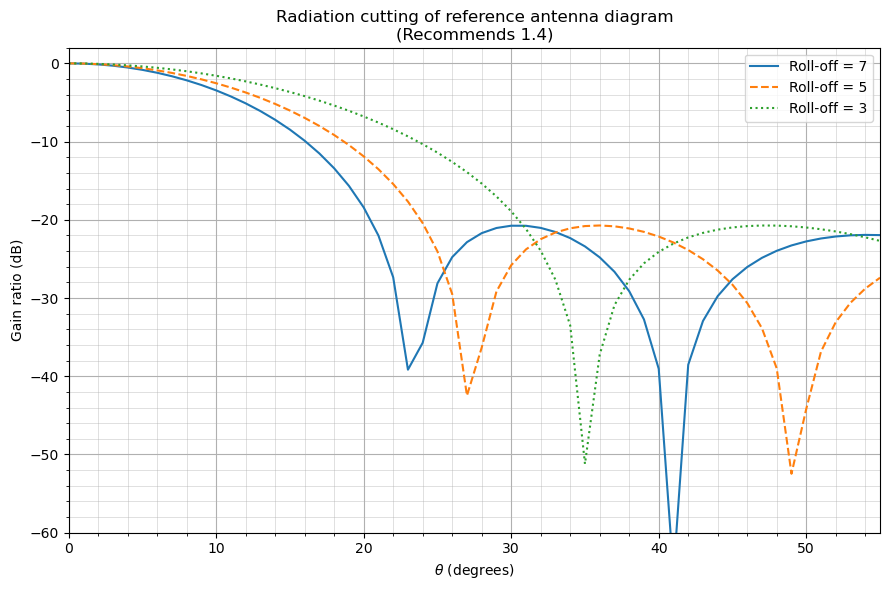

In [1]:
import numpy as np
from scipy import special as sp
try:
    from numba import njit            # optional – keeps import very cheap if absent
    _have_numba = True
except ImportError:                   # pragma: no cover
    _have_numba = False

import astropy.units as u
from pycraf import conversions as cnv
from pycraf.utils import ranged_quantity_input

from scepter.antenna import s_1528_rec1_4_pattern_amend

SLR = 20 *cnv.dB
l   = 4
alpha = np.deg2rad(13.5)
beta = np.deg2rad(13.5)
wavelength=(10.7 * u.GHz).to(u.m, equivalencies=u.spectral())

# Lr=wavelength * 0.74 / np.sin(alpha)
# Lr=wavelength * 0.74 / np.sin(beta)

# Lr=0.53*u.m
# Lt=0.53*u.m

# Table‑2 half‑beam axes (in *metres*) for the three roll‑offs
table2 = {   # roll‑off  :  (Lr , Lt)   [m]
             7 : (wavelength * 0.74 / np.sin(alpha), wavelength * 0.74 / np.sin(beta)),
             5 : (wavelength * 0.64 / np.sin(alpha), wavelength * 0.64 / np.sin(beta)),
             3 : (wavelength * 0.51 / np.sin(alpha), wavelength * 0.51 / np.sin(beta)) }
theta = np.linspace(0, 55, 55+1) * u.deg



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(9,6))
# Pick three high‑contrast colours
palette = ["#1f77b4", "#d62728", "#2ca02c"]
# ------------------------------------------------------------------
plt.figure(figsize=(9,6))
styles = {7: '-', 5: '--', 3: ':'}

for ro, (Lr, Lt) in table2.items():
    gain = s_1528_rec1_4_pattern_amend(theta, SLR=SLR, l=l,
                                 Lr=Lr, Lt=Lt).value
    plt.plot(theta, gain, styles[ro], label=f"Roll-off = {ro}")
plt.gca().set(
    xlim=(0,55), ylim=(-60,2),
    xlabel="$\\theta$ (degrees)",
    ylabel="Gain ratio (dB)",
    title="Radiation cutting of reference antenna diagram\n(Recommends 1.4)"
)
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.grid(True, which='major', linewidth=.8)
ax.grid(True, which='minor', linewidth=.4, alpha=.7)
plt.legend()
plt.tight_layout()
plt.show()